In [70]:
%matplotlib inline
# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from itertools import groupby

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO



# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer 



In [4]:
### Load data files

with open('train.csv', 'rb') as f:
    train = list(csv.reader(f))
print train[0]
print train[1]

with open('test.csv', 'rb') as f:
    test = list(csv.reader(f))
print test[0]
print test[1]

with open('sampleSubmission.csv', 'rb') as f:
    sampleSubmission = list(csv.reader(f))
print sampleSubmission[0]
print sampleSubmission[1]



['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
['2015-05-13 23:53:00', 'WARRANTS', 'WARRANT ARREST', 'Wednesday', 'NORTHERN', 'ARREST, BOOKED', 'OAK ST / LAGUNA ST', '-122.425891675136', '37.7745985956747']
['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y']
['0', '2015-05-10 23:59:00', 'Sunday', 'BAYVIEW', '2000 Block of THOMAS AV', '-122.39958770418998', '37.7350510103906']
['Id', 'ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC'

In [8]:
### This function extracts the selected features from the data files
def features(data, date_pos, dayofweek_pos, pddistric_pos, address_pos,lat_pos, long_pos):
    
    year, month,day, hour, minutes, dayofweek, districts, streets = [],[],[],[],[],[],[], []
    latitude, longitude, timestamp,date,hour_min = [],[],[],[],[]

    for i in range(1,len(data)):
        temp_data = []
        temp_data = data[i]
        year.append(temp_data[date_pos].split()[0].split("-")[0])
        month.append(temp_data[date_pos].split()[0].split("-")[1])
        day.append(temp_data[date_pos].split()[0].split("-")[2])
        hour.append(temp_data[date_pos].split()[1].split(":")[0])
        minutes.append(temp_data[date_pos].split()[1].split(":")[1])   
        dayofweek.append(temp_data[dayofweek_pos])
        districts.append(temp_data[pddistric_pos])
        streets.append(temp_data[address_pos])
        latitude.append(temp_data[lat_pos])
        longitude.append(temp_data[long_pos])
        timestamp.append(temp_data[date_pos])
        date.append(temp_data[date_pos].split()[0].split(" ")[0])
        hour_min.append(temp_data[date_pos].split()[1].split(" ")[0])

    features = [year, month, day, hour, minutes, dayofweek, districts, streets, latitude, longitude, timestamp, date, hour_min]
    return features


In [9]:
train_features = features(train,0, 3, 4,6,7,8)
for i in range (len(train_features)):
    print train_features[i][1000]

2015
05
11
11
00
Monday
SOUTHERN
0 Block of HOWARD ST
-122.392134062208
37.791697249291396
2015-05-11 11:00:00
2015-05-11
11:00:00


In [10]:
test_features = features(test,1,2,3,4,5,6)
for i in range (len(test_features)):
    print test_features[i][0]

2015
05
10
23
59
Sunday
BAYVIEW
2000 Block of THOMAS AV
-122.39958770418998
37.7350510103906
2015-05-10 23:59:00
2015-05-10
23:59:00


In [86]:
def dayofweek_transform(data,dictionary,index):
    dayofweek_new = []
    for i in range(len(data)):
        for j in range(len(dictionary)):
            if data[i][index]== dictionary.keys()[j]: dayofweek_new.append(dictionary.values()[j])
    return dayofweek_new

def dayofweek_array (dayofweek_cat,weekend):
    dayofweek_a = np.zeros((len(dayofweek_cat),2))
    for i in range (len(dayofweek_cat)):

        dayofweek_a[i,0]= float(dayofweek_cat[i])
        dayofweek_a[i,1]= float(weekend[i])
        
    return dayofweek_a

def dayofweek_transform_final(data,index):
    dayofweek_dic = {"Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4,"Friday":5, "Saturday":6,"Sunday":7 }
    weekend_dic = {"Monday":0, "Tuesday":0, "Wednesday":0, "Thursday":1,"Friday":1, "Saturday":1,"Sunday":1 }

    dayofweek_cat = dayofweek_transform(data,dayofweek_dic,index)
    weekend = dayofweek_transform(data,weekend_dic,index)
    
    week = dayofweek_array (dayofweek_cat,weekend)
    return week
week = dayofweek_transform_final(train,3)
print week.shape
print week[54000]

(878049, 2)
[ 6.  1.]


In [65]:
def coord_array(data_features):
    coord_a = np.zeros((len(data_features[4]),2))
    for i in range (len(data_features[4])):

        coord_a[i,0]= data_features[8][i]
        coord_a[i,1]= data_features[9][i]
        
    return coord_a

coordinates = coord_array (train_features)
print coordinates.shape
print coordinates[54000]  
    

(878049, 2)
[-122.40653912   37.75648641]


In [93]:
def timestamp_transform(data,index):
    timestamp_new, date_new, time_new = [], [], []
    time_attr = ['year', 'month', 'day','hour','minute']
    for i in range(1,len(data)):
        ts = datetime.datetime.strptime(data[i][index], '%Y-%m-%d %H:%M:%S')
        
        ts_attr = []
        for attr in time_attr: 
            ts_attr.append(int(getattr(ts, attr)))

        dt = datetime.date(ts_attr[0],ts_attr[1],ts_attr[2] )
        t = datetime.time(ts_attr[3],ts_attr[4] )
        date_new.append(dt)
        time_new.append(t)
        timestamp_new.append(ts)

    time_transform = [timestamp_new,date_new, time_new]
    return time_transform
        
def find_minimum(time_transform):
    timestamp_min = []
    for i in range(3):
        for j in range(len(time_transform[i])):
            if j == 0:
                local_min = time_transform[i][0]
    
            else: 
                local_min = min(local_min, time_transform[i][j])
                       
        
        timestamp_min.append(local_min)
    return timestamp_min

def timedelta_transform(start_time,time_transform):
    unit = ['D', 'D']
    timestamp_delta = np.zeros((3, len(time_transform[1])))
    for i in range (2):
        for j in range (len(time_transform[i])):
            timestamp_delta[i,j] = (np.datetime64(time_transform[i][j])-np.datetime64(start_time[i]))/np.timedelta64(1,unit[i])
    
    timestamp_delta = np.transpose(timestamp_delta)
    
    from datetime import datetime
    from datetime import timedelta
    start = str(start_time[2])
    FMT = "%H:%M:%S"
    for i in range (timestamp_delta.shape[0]):
        end = str(time_transform[2][i]) 
        diff = datetime.strptime(end, FMT) -  datetime.strptime(start, FMT)
        diff = diff.total_seconds()/60
        timestamp_delta[i,2] = diff
    
    return timestamp_delta

def timestamp_transform_final(data,index):
    import datetime, time
    timestamp = timestamp_transform(data,index)
    start_time = find_minimum(timestamp)
    delta = timedelta_transform(start_time,timestamp)
    return delta

times = timestamp_transform_final(train,0)

print times.shape
print times[54000]     

(878049, 3)
[ 4247.72638889  4247.          1046.        ]


In [95]:
def continuos_data(data, data_features,index_w, index_t):
    week = dayofweek_transform_final(data,index_w) ## index = 3 for train and index = 2 for test data
    coordinates = coord_array (data_features)
    times = timestamp_transform_final(data,index_t) ### index = 0 for train and index = 1 for test data
    d = np.hstack((times, week, coordinates))
    return d

train_data_c = continuos_data(train,train_features,3,0)
print train_data_c.shape

(878049, 7)


In [96]:
test_data_c = continuos_data(test,test_features,2,1)
print test_data_c.shape

NameError: name 'test_data_cont' is not defined

In [97]:
print test_data_c.shape

(884262, 7)


In [287]:
## This function vectorizes the features on both the train and the test data
def vector_features_lists(train_features, test_features):
    vectorizer = CountVectorizer(min_df=1)
    train_vector_features, test_vector_features, feature_labels = [], [], []
    for i in range (len(train_features)):
        train_vector_features.append(vectorizer.fit_transform(train_features[i]))
        test_vector_features.append(vectorizer.transform(test_features[i]))
        feature_labels.append(vectorizer.get_feature_names())
    vector_features_lists = [train_vector_features, test_vector_features, feature_labels]
    return vector_features_lists






In [288]:
lists = vector_features_lists(train_features, test_features)




In [289]:
train_lists = lists[0] 
test_lists = lists[1]
feature_labels = lists[2]

In [290]:
### This function converts the vectorized features into an array
def vector_features_array(vector_features_list):
    for i in range (len(vector_features_list)):
        array = vector_features_list[i].toarray()
        if i == 0:
            vector_features_array = array
        else:
            vector_features_array = np.concatenate([vector_features_array, array], axis = -1)
    
    return vector_features_array


In [291]:
X_data = vector_features_array(train_lists)
X_test = vector_features_array(test_lists)

In [292]:
print len(feature_labels)
print feature_labels[0:100]

8
[[u'2003', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015'], [u'01', u'02', u'03', u'04', u'05', u'06', u'07', u'08', u'09', u'10', u'11', u'12'], [u'01', u'02', u'03', u'04', u'05', u'06', u'07', u'08', u'09', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21', u'22', u'23', u'24', u'25', u'26', u'27', u'28', u'29', u'30', u'31'], [u'00', u'01', u'02', u'03', u'04', u'05', u'06', u'07', u'08', u'09', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21', u'22', u'23'], [u'00', u'01', u'02', u'03', u'04', u'05', u'06', u'07', u'08', u'09', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21', u'22', u'23', u'24', u'25', u'26', u'27', u'28', u'29', u'30', u'31', u'32', u'33', u'34', u'35', u'36', u'37', u'38', u'39', u'40', u'41', u'42', u'43', u'44', u'45', u'46', u'47', u'48', u'49', u'50', u'51', u'52', u'53', u'54', u'55', u'56', u'5

In [293]:
print X_data.shape
print X_test.shape


(878049, 2298)
(884262, 2298)


In [294]:
### This function extracts the data labels from the train data
def labels(data):
    
    labels = []

    for i in range(1,len(data)):
        temp_data = []
        temp_data = data[i]
        labels.append(temp_data[1])

    return labels

labels = labels(train)

classifications = sorted(set(labels))
print classifications
print len(classifications)
print len(sampleSubmission[0])


['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS']
39
40


In [295]:
Y_labels = np.zeros((len(labels),))
print Y_labels.shape
for i in range (Y_labels.shape[0]):
    for j in range (len(classifications)):
        if labels[i] == classifications[j]:
                     Y_labels[i] = j
print labels[0]
print Y_labels[0]

(878049,)
WARRANTS
37.0


In [296]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X_data.shape[0]))
X_data, Y_labels = X_data[shuffle], Y_labels[shuffle]



In [297]:
# Split into train and dev.
train_data, train_labels = X_data[:700000], Y_labels[:700000]
dev_data, dev_labels = X_data[700000:], Y_labels[700000:]
mini_train_data, mini_train_labels = train_data[:50000], train_labels[:50000]
mini_dev_data, mini_dev_labels = dev_data[:1000], dev_labels[:1000]
print mini_train_data.shape
print mini_train_labels.shape

(50000, 2298)
(50000,)


In [298]:
print mini_dev_data.shape
print mini_dev_labels.shape

(1000, 2298)
(1000,)


In [70]:
### K-NearestNeighbour Classifier 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(mini_train_data,mini_train_labels)
y_pred = knn.predict(mini_dev_data)

In [71]:
print classification_report(mini_dev_labels, y_pred )

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       0.08      0.18      0.11        89
        2.0       0.00      0.00      0.00         1
        4.0       0.10      0.26      0.15        43
        5.0       0.00      0.00      0.00         7
        6.0       0.00      0.00      0.00         5
        7.0       0.22      0.33      0.27        70
        8.0       0.00      0.00      0.00         1
        9.0       0.00      0.00      0.00         1
       11.0       0.00      0.00      0.00         0
       12.0       0.07      0.05      0.06        19
       13.0       0.00      0.00      0.00        13
       15.0       0.00      0.00      0.00         1
       16.0       0.26      0.43      0.33       178
       17.0       0.00      0.00      0.00         1
       18.0       0.00      0.00      0.00         2
       19.0       0.14      0.16      0.15        31
       20.0       0.15      0.07      0.10   

In [72]:
### Multinomial Classifier
mn = MultinomialNB(alpha=0.5)
mn.fit(mini_train_data, mini_train_labels)
y_pred = mn.predict(mini_dev_data)

In [73]:
print classification_report(mini_dev_labels, y_pred )

             precision    recall  f1-score   support

        1.0       0.20      0.16      0.17        89
        2.0       0.00      0.00      0.00         1
        4.0       0.06      0.02      0.03        43
        5.0       0.00      0.00      0.00         7
        6.0       0.00      0.00      0.00         5
        7.0       0.34      0.47      0.39        70
        8.0       0.00      0.00      0.00         1
        9.0       0.00      0.00      0.00         1
       12.0       0.00      0.00      0.00        19
       13.0       0.00      0.00      0.00        13
       15.0       0.00      0.00      0.00         1
       16.0       0.28      0.65      0.39       178
       17.0       0.00      0.00      0.00         1
       18.0       0.00      0.00      0.00         2
       19.0       0.25      0.26      0.25        31
       20.0       0.17      0.11      0.13       109
       21.0       0.31      0.36      0.34       138
       23.0       0.29      0.60      0.39   

In [76]:
### Logistic Regression
lr = LogisticRegression(C=0.5)
lr.fit(mini_train_data,mini_train_labels)
y_pred = lr.predict(mini_dev_data)

In [75]:
print classification_report(mini_dev_labels, y_pred )

             precision    recall  f1-score   support

        1.0       0.16      0.13      0.15        89
        2.0       0.00      0.00      0.00         1
        4.0       0.09      0.02      0.04        43
        5.0       0.00      0.00      0.00         7
        6.0       0.00      0.00      0.00         5
        7.0       0.35      0.30      0.32        70
        8.0       0.00      0.00      0.00         1
        9.0       0.00      0.00      0.00         1
       12.0       0.00      0.00      0.00        19
       13.0       0.00      0.00      0.00        13
       15.0       0.00      0.00      0.00         1
       16.0       0.26      0.72      0.39       178
       17.0       0.00      0.00      0.00         1
       18.0       0.00      0.00      0.00         2
       19.0       0.40      0.19      0.26        31
       20.0       0.16      0.06      0.09       109
       21.0       0.28      0.46      0.35       138
       23.0       0.38      0.50      0.43   

In [301]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(mini_train_data, mini_train_labels)
y_pred = dt.predict(mini_dev_data)

In [336]:
print classification_report(mini_dev_labels, y_pred )
print dt.score(mini_dev_data, mini_dev_labels)
print dt.feature_importances_

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         2
        1.0       0.12      0.11      0.11        82
        2.0       0.00      0.00      0.00         1
        3.0       0.00      0.00      0.00         1
        4.0       0.04      0.05      0.04        39
        5.0       0.00      0.00      0.00         5
        6.0       0.00      0.00      0.00         6
        7.0       0.24      0.28      0.26        53
        8.0       0.33      0.25      0.29         4
        9.0       0.00      0.00      0.00         0
       10.0       0.00      0.00      0.00         1
       11.0       0.00      0.00      0.00         2
       12.0       0.00      0.00      0.00        11
       13.0       0.06      0.05      0.05        19
       15.0       0.00      0.00      0.00         3
       16.0       0.39      0.41      0.40       224
       17.0       0.00      0.00      0.00         2
       18.0       0.00      0.00      0.00   

In [77]:
print X_test.shape

(884262, 2298)


In [78]:
### Prediction for test data
y_pred = mn.predict(X_test)

In [79]:
### This function extracts the id from the test data file
def testid(data):
    
    testid = []

    for i in range(1,len(data)):
        temp_data = []
        temp_data = data[i]
        testid.append(temp_data[0])

    return testid

testid = testid(test)
print len(testid)
print testid[0]


884262
0


In [110]:
submitfile = np.zeros((len(y_pred), len(classifications)))
for i in range (len(y_pred)):
    for j in range (len(classifications)):
        if classifications[int(y_pred[i])]==classifications[j]:
            submitfile[i,j]=1
        else:
            submitfile[i,j]=0
        
print submitfile.shape
print submitfile[1]

(884262, 39)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


In [112]:
test_lab_f = open("submission.csv", "w") # writing final results on a csv file

test_lab_f.write(sampleSubmission[0][0])
for j in range(len(classifications)):
    test_lab_f.write( "," + str(sampleSubmission[0][j+1]))

idx = 0
                 
for i in range(len(y_pred)):
    
    test_lab_f.write("\n")
    test_lab_f.write(str(idx))
    for j in range(len(classifications)):
        test_lab_f.write( "," + str(int(submitfile[i,j])))
    idx += 1
   

test_lab_f.close()

In [217]:

features_set = ['year', 'month', 'day', 'hour', 'minutes', 'dayofweek', 'districts', 'streets']
def getindex(variable):
    index = 0
    for i in range(len(features_set)):
        if features_set[i]==variable: index = i
    return index

def tidy_data(variable):
    index = getindex(variable)
    indep_var = train_features[index]
    depen_var = labels
    tuple_list = zip(indep_var, depen_var)
    tuple_set = list(set(tuple_list))
    tuple_count = []
    for i in range(len(tuple_set)):
        counter = tuple_list.count(tuple_set[i])
        tuple_count.append(counter)
    data = []
    for i in range(len(tuple_set)):
        row = tuple_set[i] + (tuple_count[i],)
        data.append(row)
    return data



In [261]:
def class_group(variable):
    data = tidy_data(variable)
    data = sorted(data,key=lambda item: item[0])
    groups = []
    uniquekeys = []
    for k, g in groupby(data, lambda item: item[0]):
        groups.append(list(g))      # Store group iterator as a list
        uniquekeys.append(k)
### calculate total per group    
    groups_total = []
    for k in range(len(uniquekeys)):
        group_sum = 0
        for i in range(len(groups[k])):
            add_freq = groups[k][i][2]
            group_sum += add_freq
        groups_total.append(group_sum)

### Assign probabilities
    data_prob = []
    for k in range(len(uniquekeys)):
        for i in range(len(groups[k])):
            prob = float(groups[k][i][2])/float(groups_total[k])
            row = groups[k][i]+(prob,)
            data_prob.append(row)
        
    return data_prob

In [330]:
def plotting_x(variable):
    index = getindex(variable)
    data = class_group(variable)
    data = sorted(data,key=lambda item: item[0])
    data = pd.DataFrame(data, columns=[features_set[index], 'crime','freq','prob']) 
    sns.set(style="whitegrid", color_codes=True)
    dims = (16, 32)
    fig, ax = plt.subplots(figsize=dims)
    sns.stripplot(x=features_set[index], y='prob', hue='crime', data=data, jitter=True, size=10,ax=ax)
    plt.yticks([0,0.05, 0.1, 0.15,0.20,0.25])
    plt.savefig("output.png")

In [333]:
from scipy import stats
import matplotlib as mpl

def plotting_y(variable):
    index = getindex(variable)
    data = class_group(variable)
    data = sorted(data,key=lambda item: item[2], reverse=True)
    data = pd.DataFrame(data, columns=[features_set[index], 'crime','freq', 'prob']) 
    sns.set(style="whitegrid", color_codes=True)
    dims = (16, 32)
    fig, ax = plt.subplots(figsize=dims)
##sns.violinplot(x="freq", y="crime", hue='district',data=data, ax=ax)
    sns.stripplot(x="prob", y=features_set[index], hue='crime', data=data, jitter=True, size=10,ax=ax)
    plt.xticks([0,0.05, 0.1, 0.15,0.20,0.25])
    plt.savefig("output.png")




In [269]:
import heapq, random

def plotting_max50(variable):
    index = getindex(variable)
    data = tidy_data(variable)
    data = sorted(data,key=lambda item: item[2], reverse=True)
    data = heapq.nlargest(50, data,key=lambda item: item[2] )
    data = pd.DataFrame(data, columns=[features_set[index], 'crime','freq']) 
    sns.set(style="whitegrid", color_codes=True)
    dims = (16, 32)
    fig, ax = plt.subplots(figsize=dims)
##sns.violinplot(x="freq", y="crime", hue='district',data=data, ax=ax)
    sns.stripplot(x="freq", y=features_set[index], hue='crime', data=data, jitter=True, size=10,ax=ax)

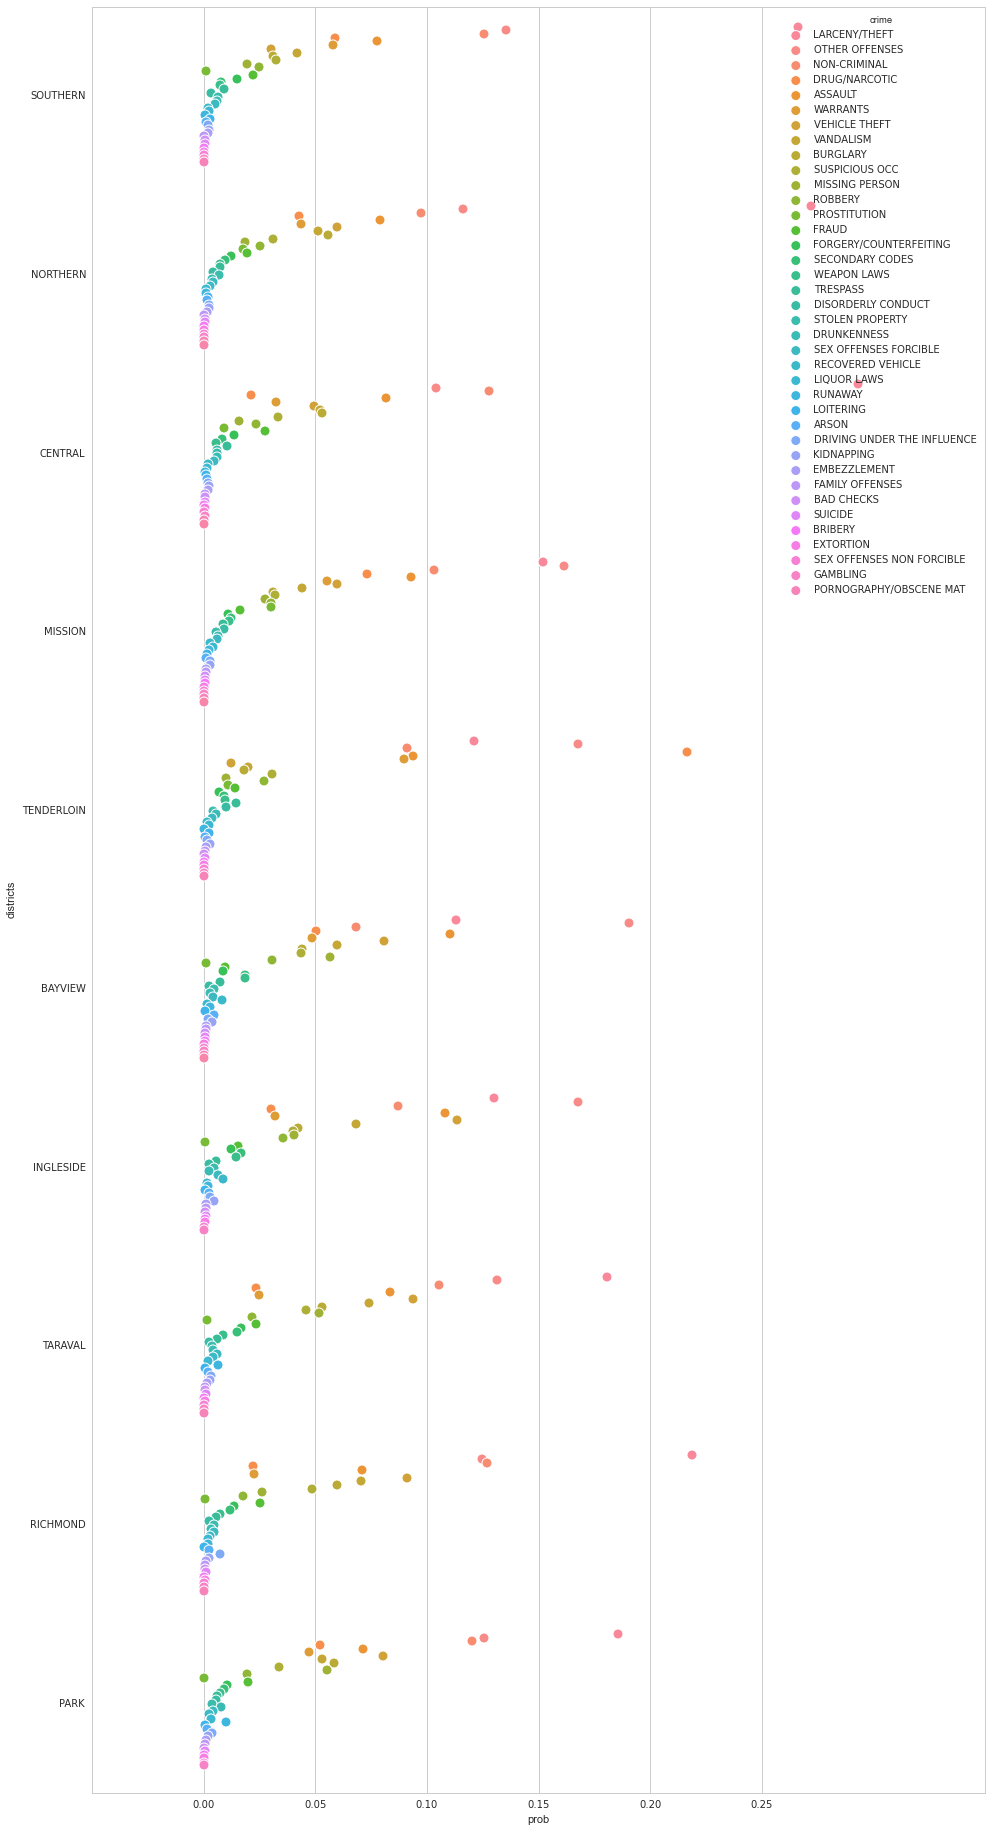

In [334]:
plotting_y('districts')

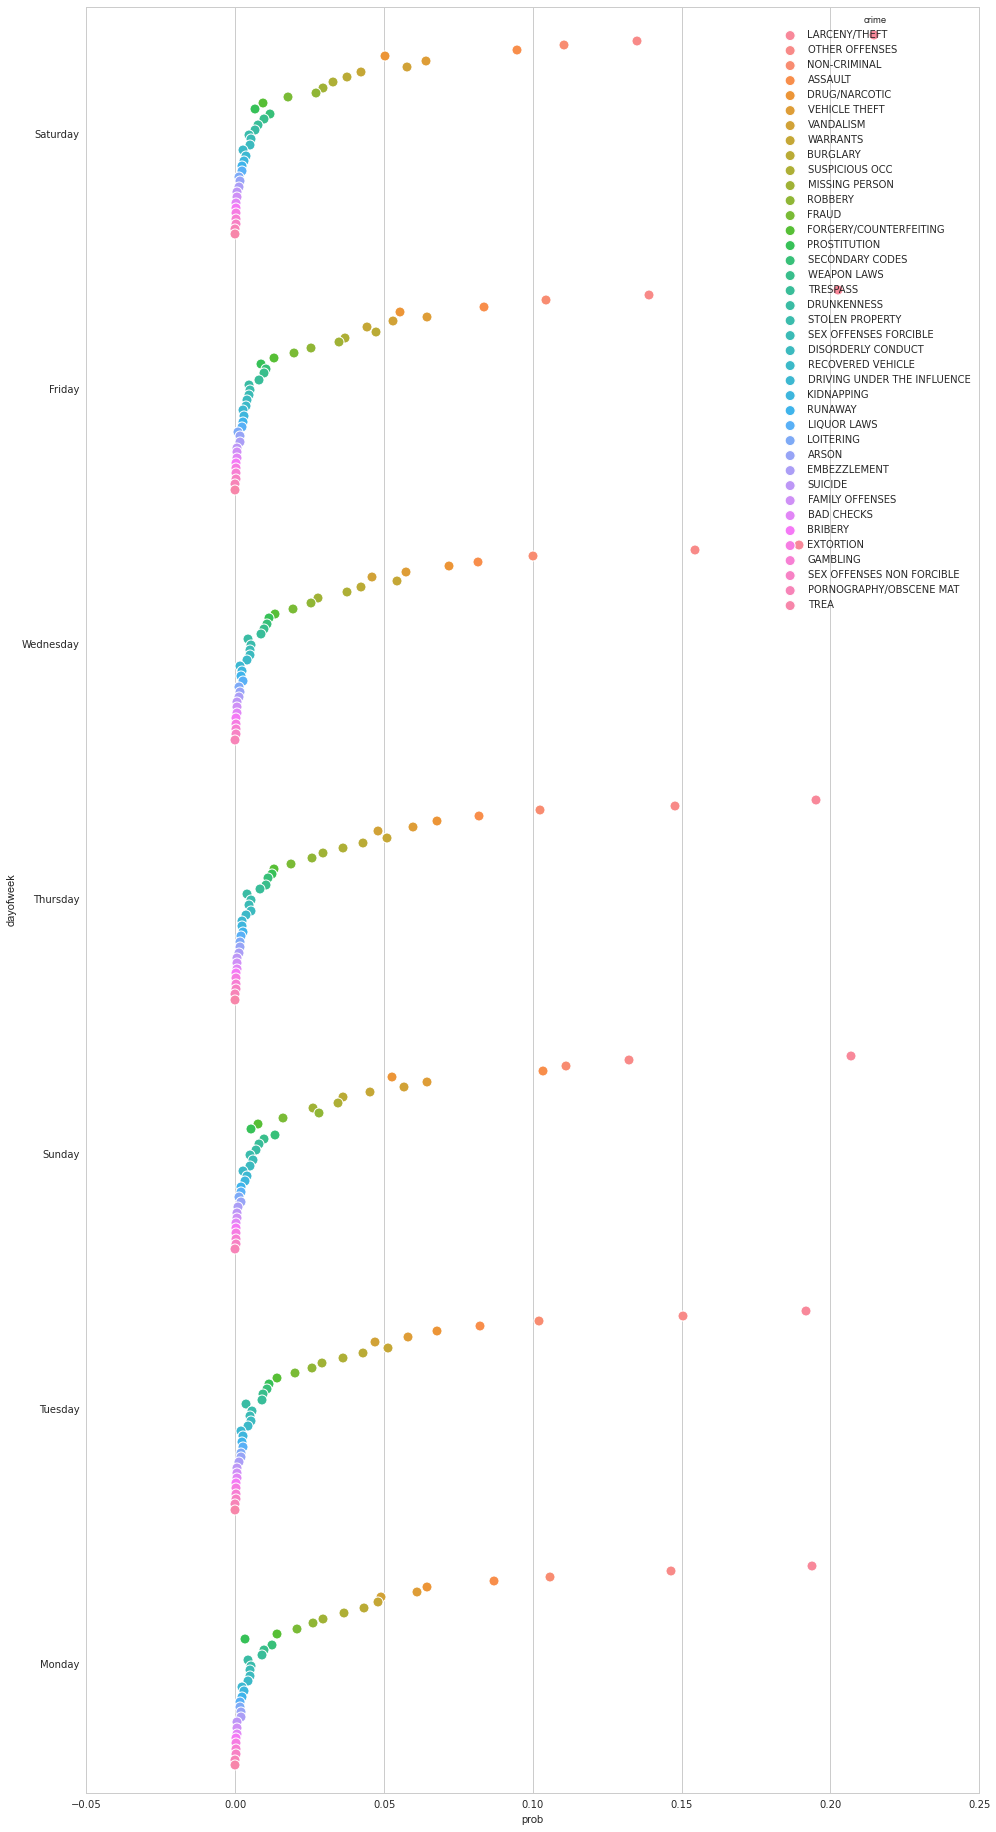

In [311]:
plotting_y('dayofweek')

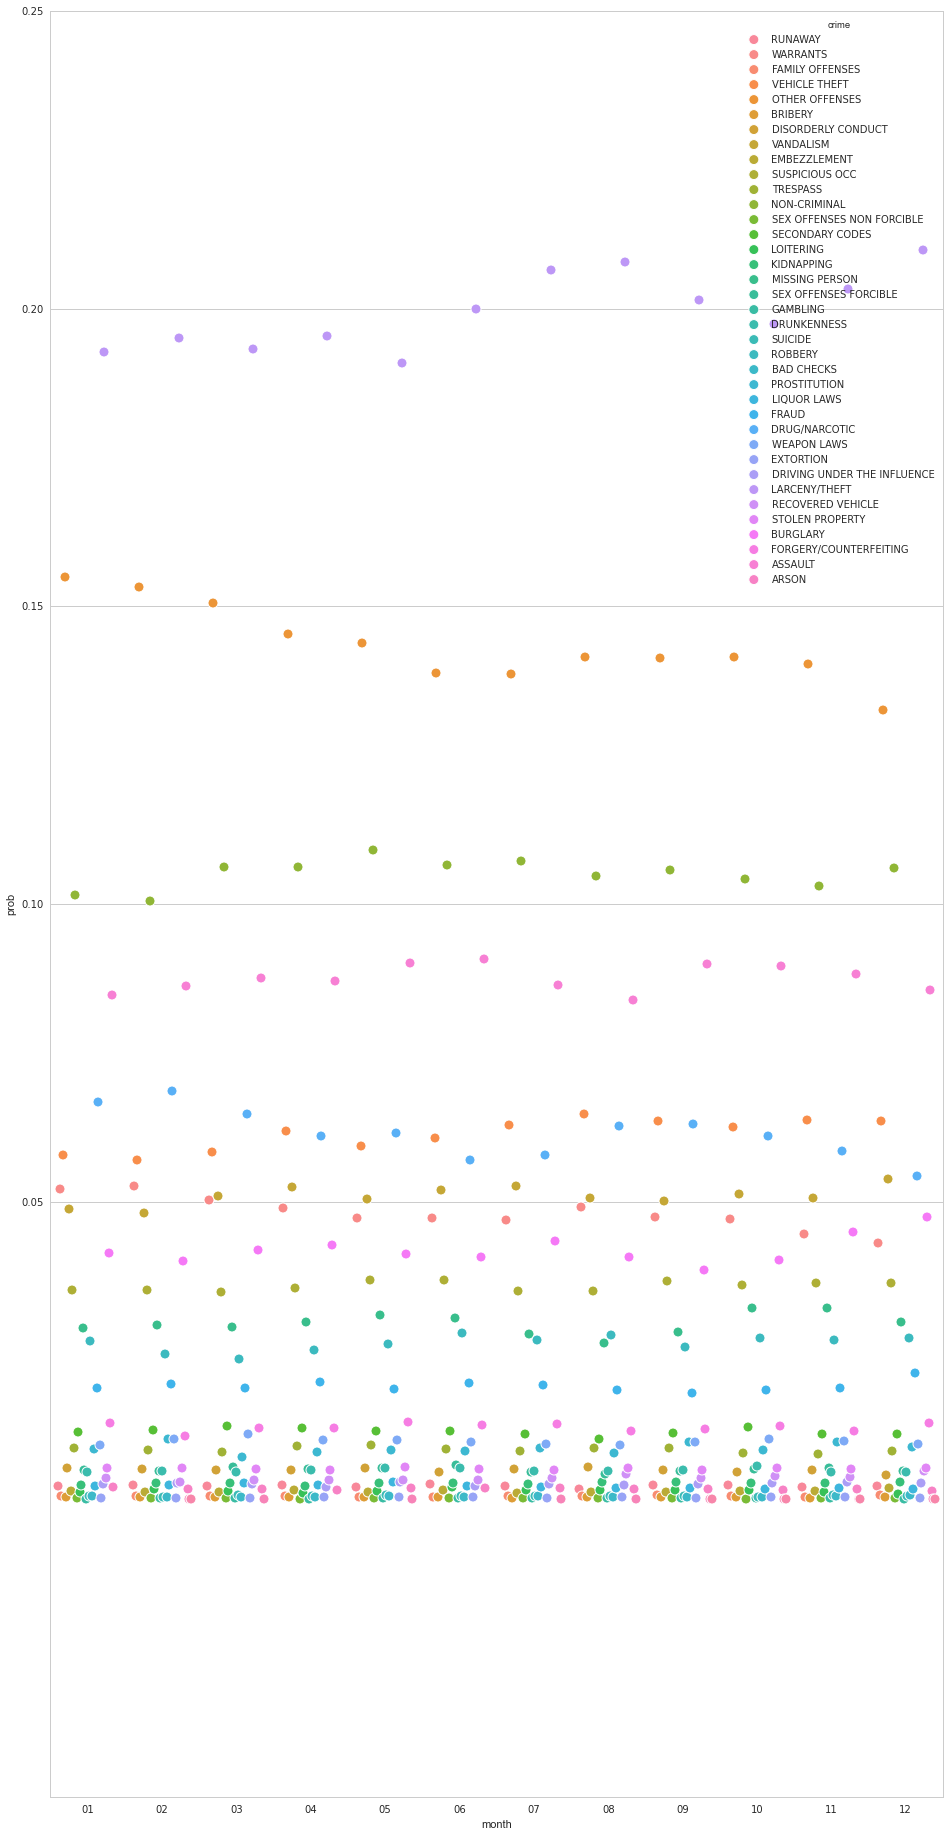

In [329]:
plotting_x('month')

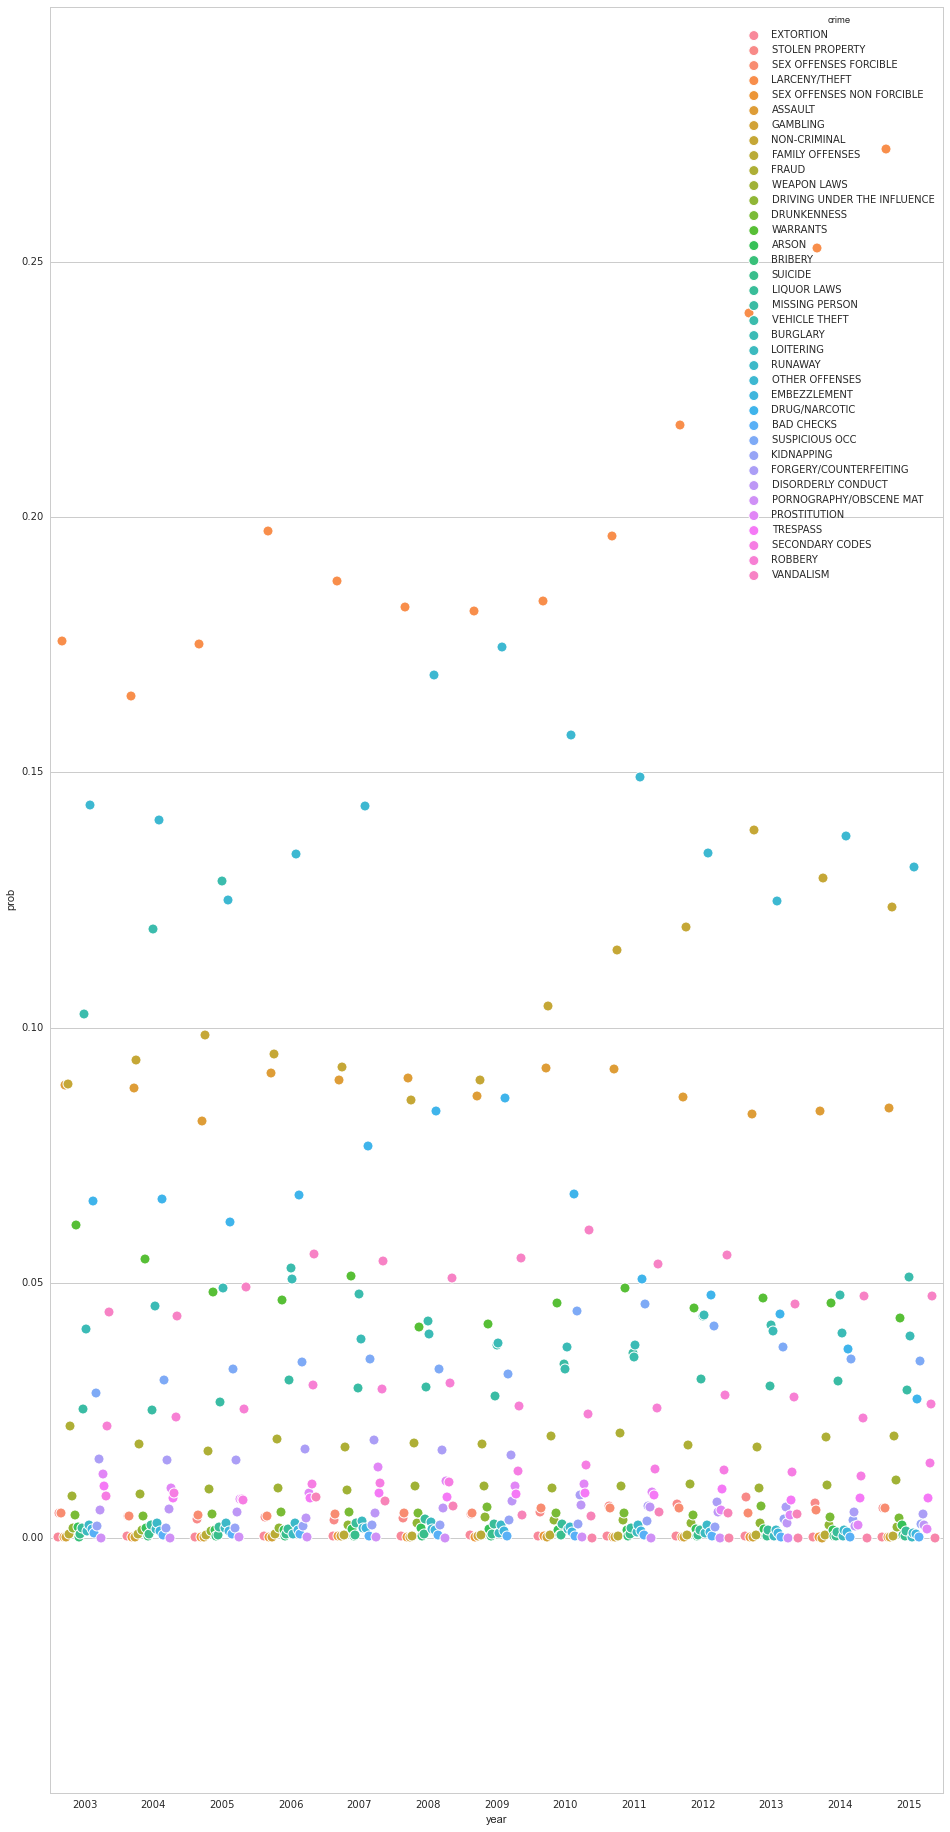

In [335]:
plotting_x('year')

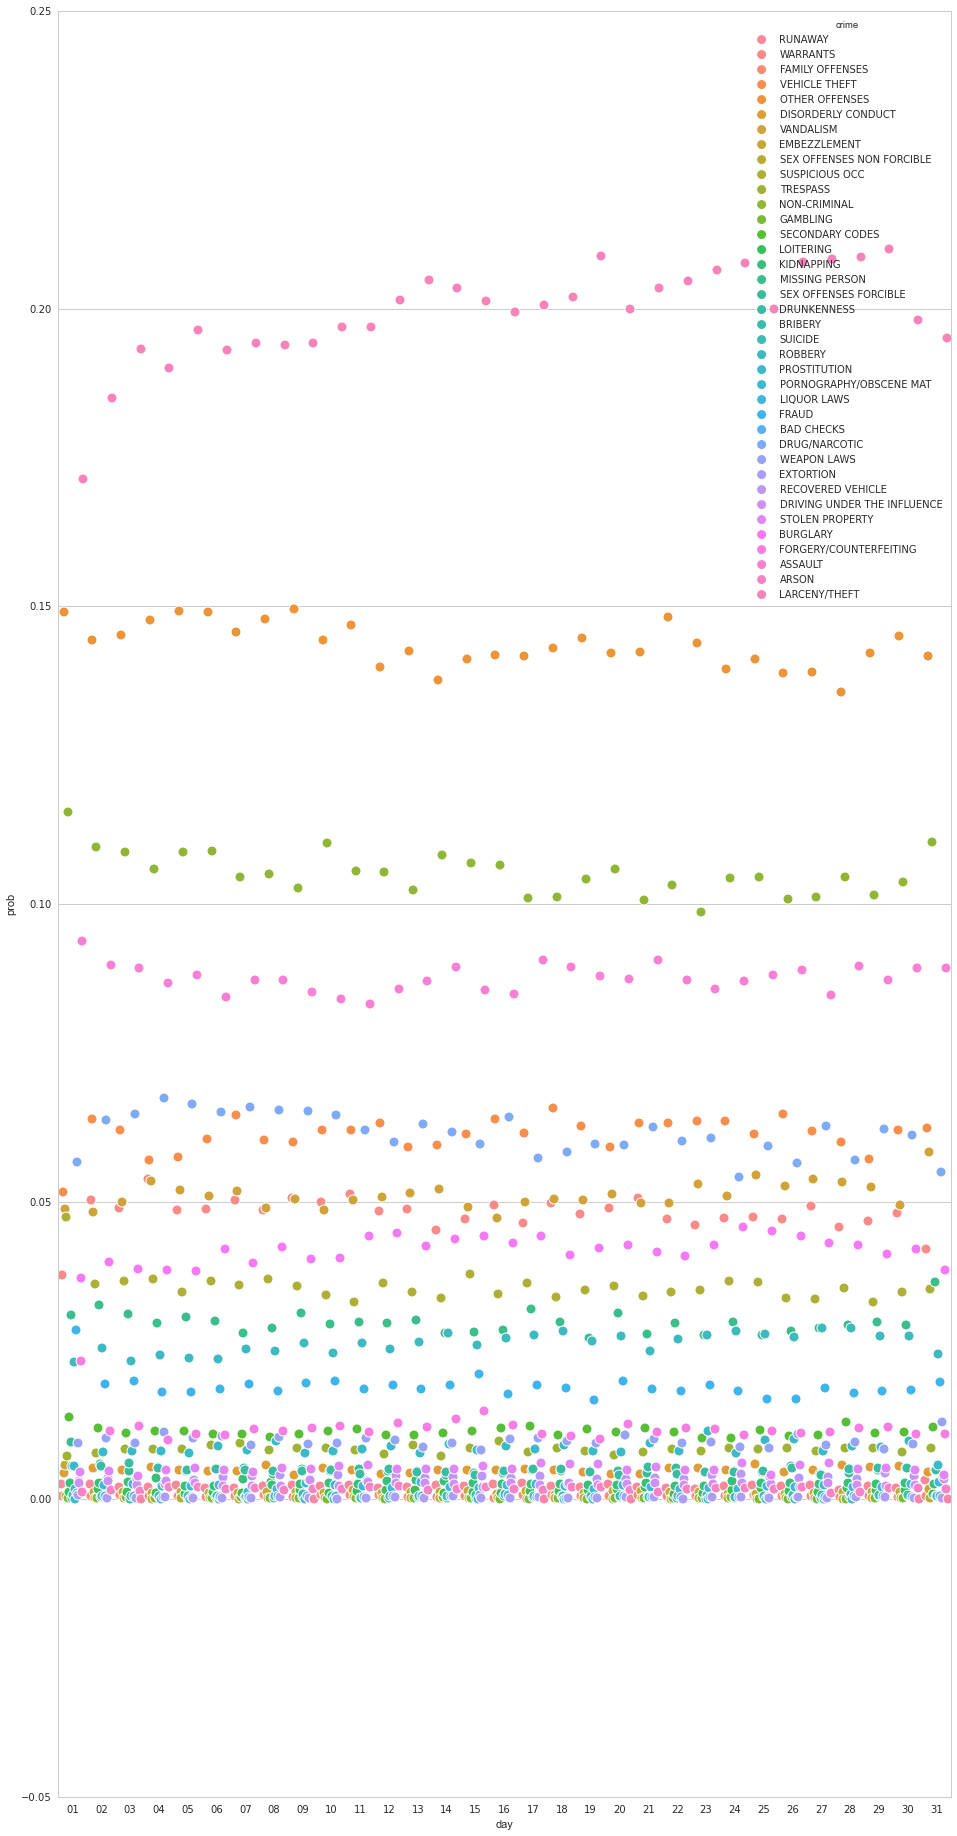

In [314]:
plotting_x('day')

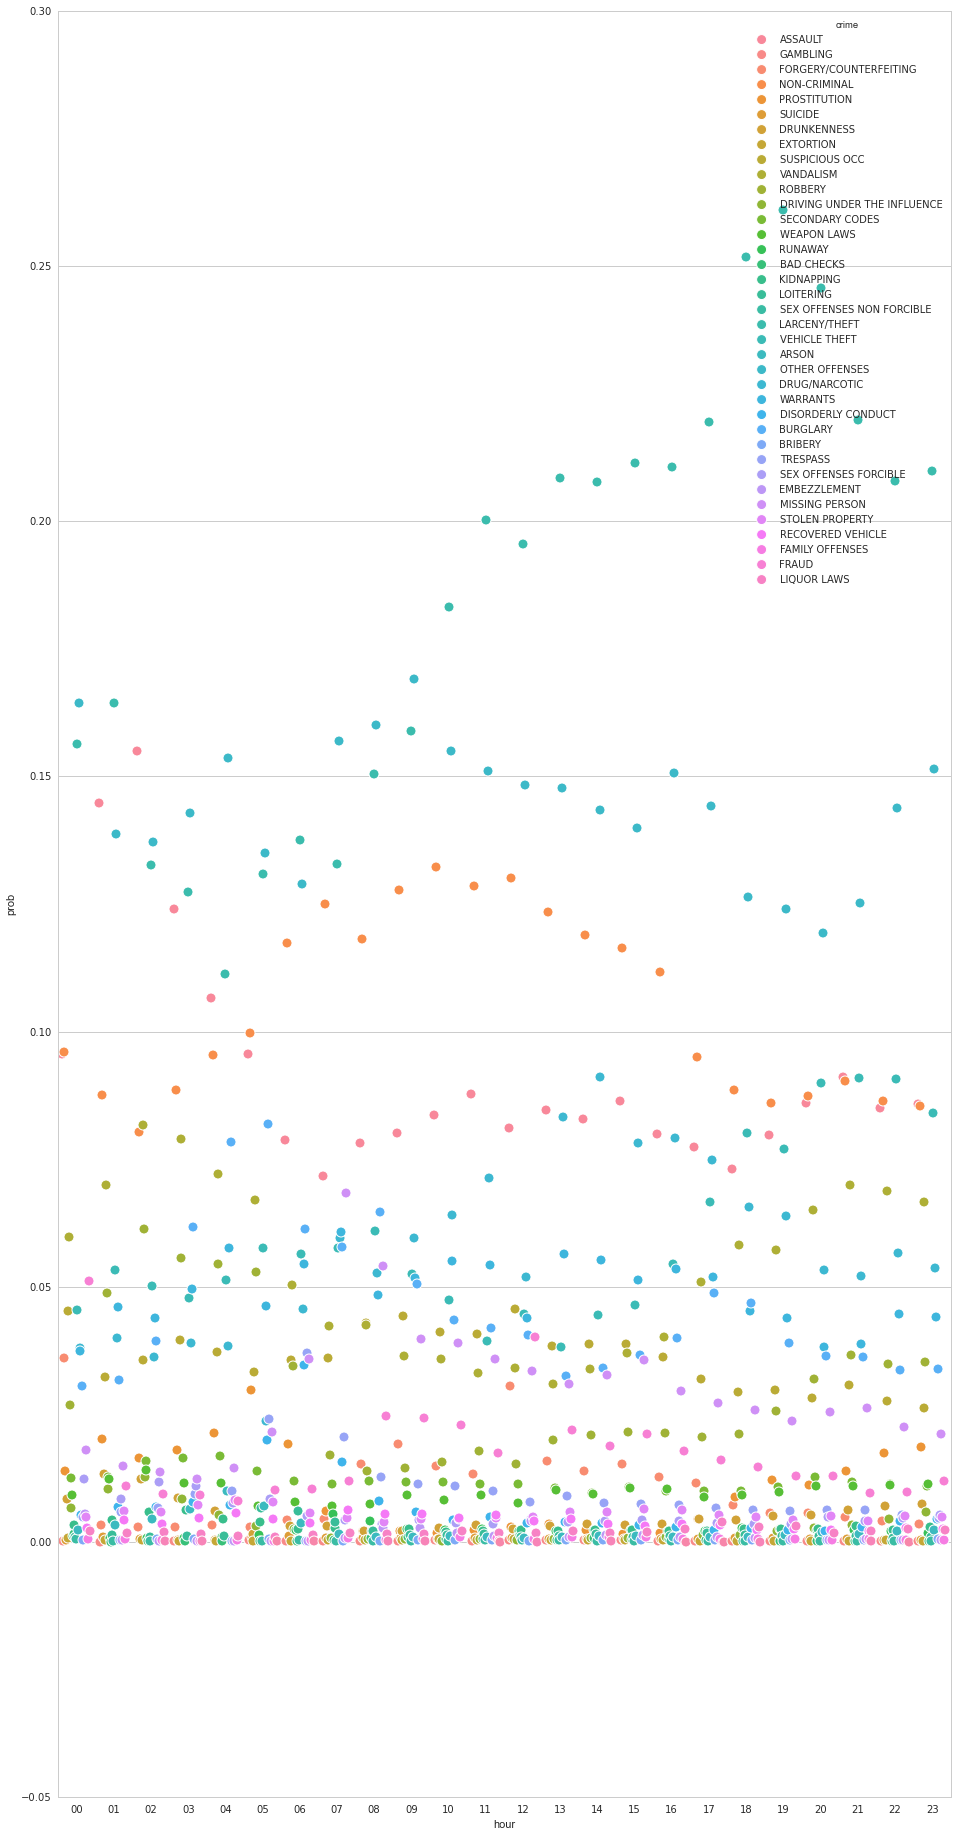

In [315]:
plotting_x('hour')

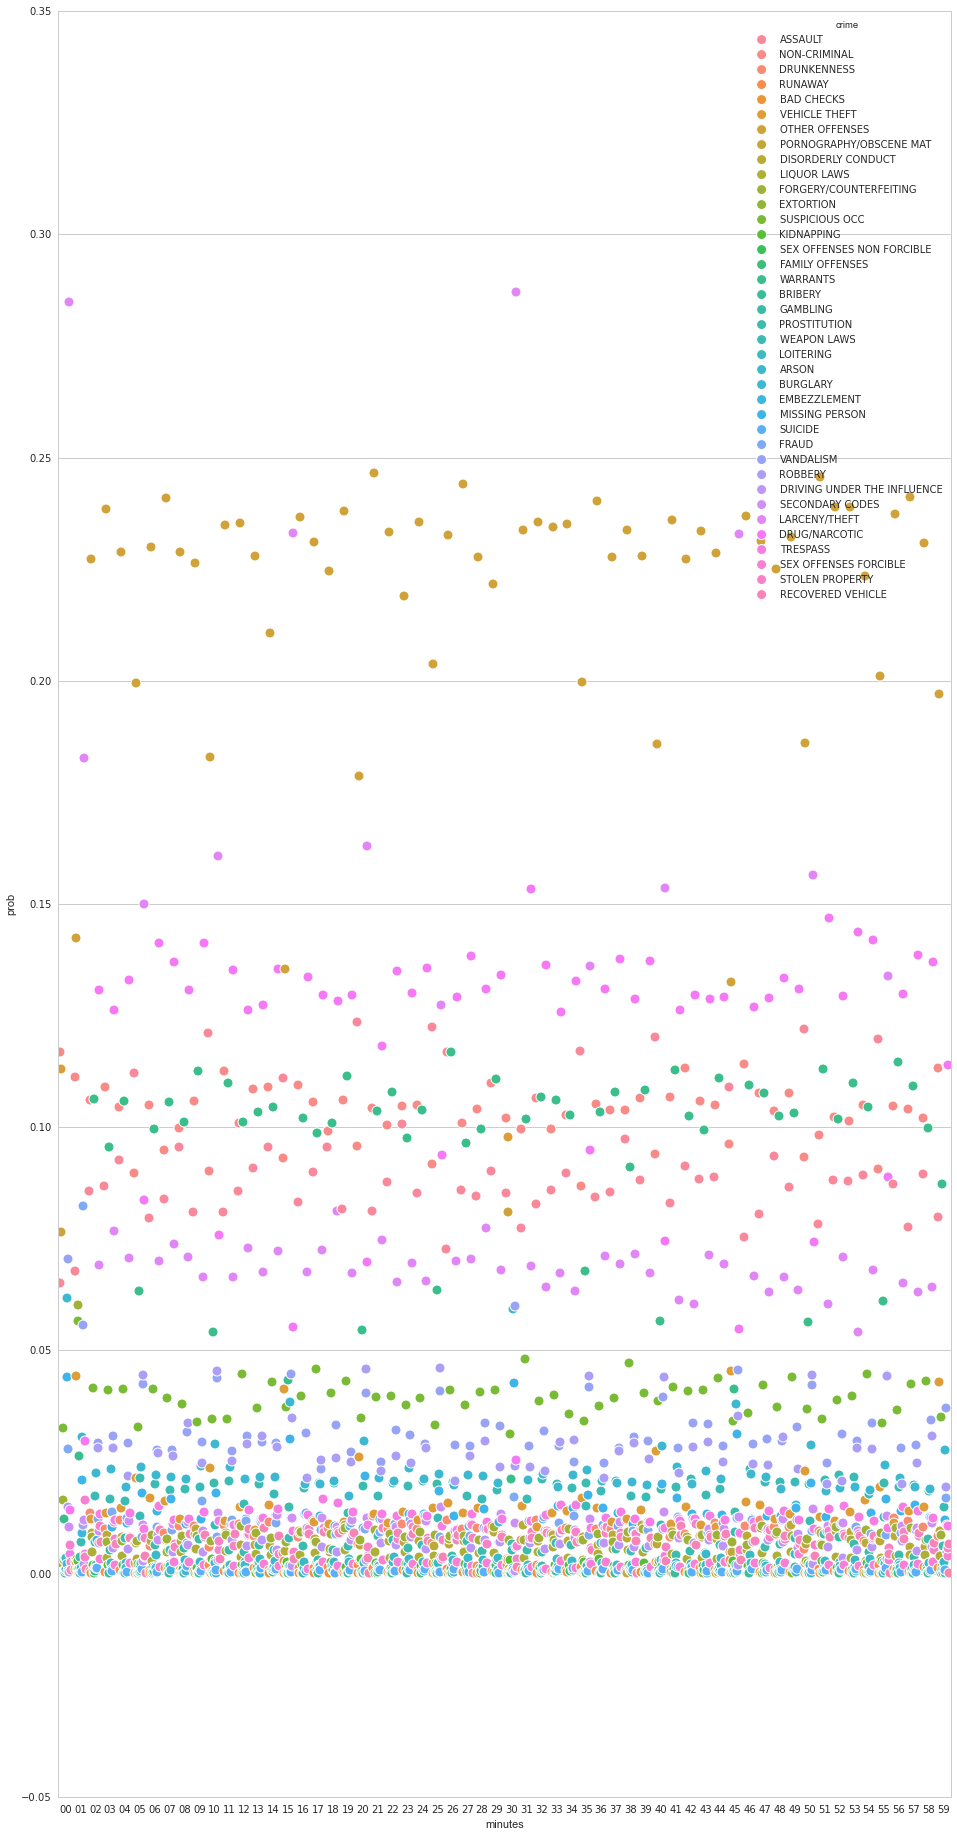

In [316]:
plotting_x('minutes')

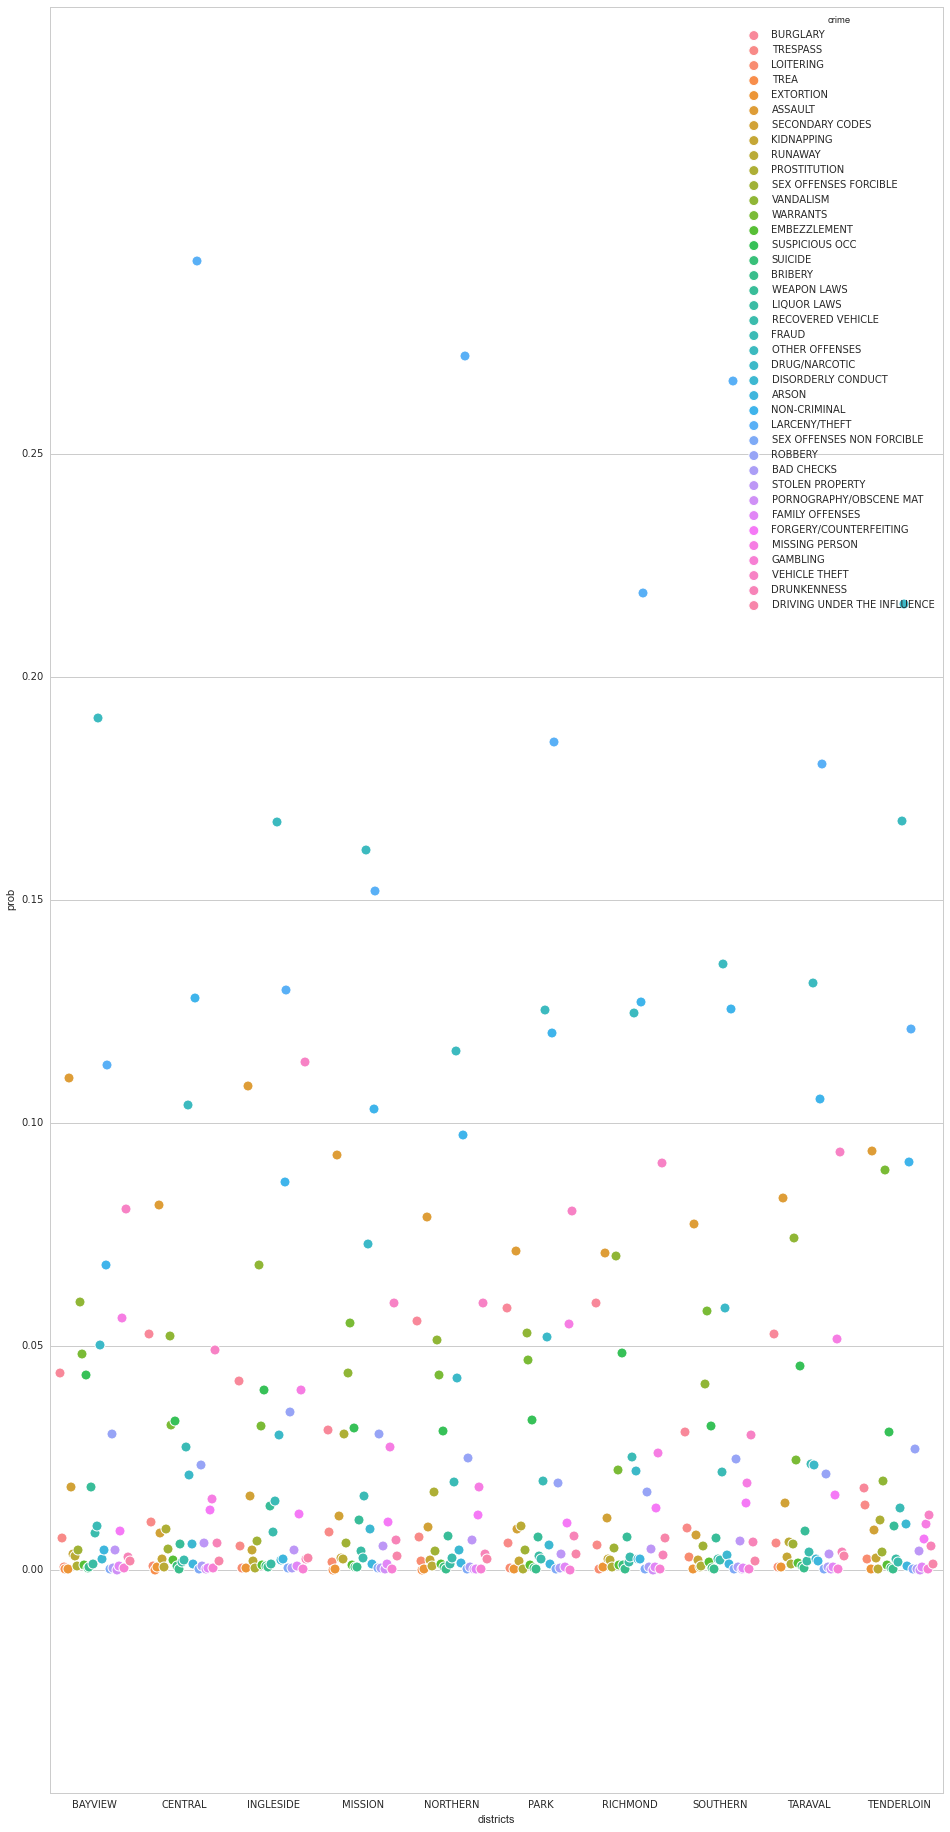

In [337]:
plotting_x('districts')